In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from math import radians, cos, sin, asin, sqrt
from scipy.stats import pearsonr
from scipy.stats import spearmanr
from sklearn import linear_model

In [59]:
calendar = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/calendar.csv")
real_estate = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/real_estate.csv")
demographics = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/demographics.csv")
econ_state = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/econ_state.csv")
listings = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/listings.csv", thousands = ',')
venues = pd.read_csv("/Users/chrisfan/Desktop/citadel_datathon/venues.csv")

In [60]:
listing_prices = listings['price'].str.replace('$', '')
listing_prices = listing_prices.str.replace(',', '')
listing_prices = pd.to_numeric(listing_prices)

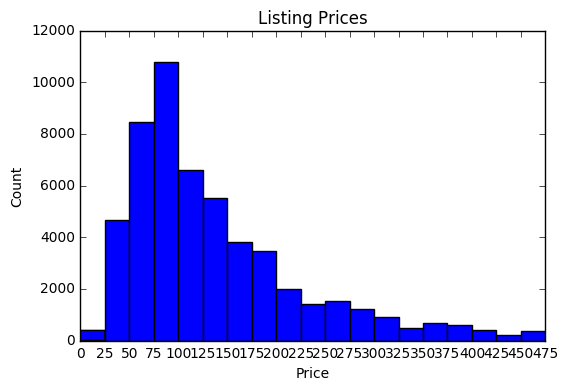

In [61]:
plt.xticks(range(0, 500, 25))
plt.hist(listing_prices, bins = range(0, 500, 25))
plt.title("Listing Prices")
plt.xlabel("Price")
plt.ylabel("Count")
plt.show()

In [62]:
average_price = sum(listing_prices) / float(len(listing_prices))
print(average_price)
print(listing_prices.median())

186.131272489
111.0


In [63]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance between two points
    on the earth (specified in decimal degrees)
    http://stackoverflow.com/questions/15736995/
    how-can-i-quickly-estimate-the-distance-between-two-latitude-longitude-points
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    km = 6367 * c
    return km

In [64]:
city_to_listing = {}

for city in venues['city'].unique():
    city_to_listing[city] = []
for i in range(len(listings)):
    city = listings["city"].iloc[i]
    x = listings['longitude'].iloc[i]
    y = listings['latitude'].iloc[i]
    zipcode = listings['zipcode'].iloc[i]
    if city in city_to_listing:
        city_to_listing[city].append([x, y, zipcode])

In [67]:
venue_to_zip = {}
        
for i in range(len(venues)): 
    if (i % 100 == 0):
        print i
    v_x = venues['longitude'].iloc[i]
    v_y = venues['latitude'].iloc[i]
    min_dist = city_to_listing[venues['city'].iloc[i]][0]
 
    for x in city_to_listing[venues['city'].iloc[i]]:
        if haversine(v_x, v_y, x[0], x[1]) < haversine(v_x, v_y, min_dist[0],min_dist[1]):
            min_dist = x
    venue_to_zip[venues['id'].iloc[i]] = min_dist[2]

0
100
200
300
400
500
600
700
800
900
1000
1100
1200
1300
1400
1500
1600
1700
1800
1900
2000
2100
2200
2300
2400
2500


KeyboardInterrupt: 

In [ ]:
print(city_to_listing['seattle'][0][1])
print(city_to_listing['seattle'][0][2])

In [124]:
real_estate_agg = {}
for i in range(len(real_estate)):
    zipcode = str(real_estate["zipcode"].iloc[i])
    score = int(real_estate["2017-06"].iloc[i])
    if zipcode not in real_estate_agg:
        real_estate_agg[zipcode] = [score]
    

In [125]:
zipcode_to_city_map = {}
for i in range(len(real_estate)):
    zipcode = str(real_estate["zipcode"].iloc[i])
    city = real_estate["city"].iloc[i]
    state = real_estate["state"].iloc[i]
    
    zipcode_to_city_map[zipcode] = city + "," + state

In [126]:
def zip_code_filter(room_type_input, property_type_input, sample_threshold   ):
    zip_code_agg = {}
    for i in range(len(listings)):

        room_type = listings["room_type"].iloc[i]
        property_type = listings["property_type"].iloc[i]
        
        
        
        
        if room_type  == room_type_input:
            if property_type == property_type_input:  
                zipcode = listings["zipcode"].iloc[i]
                price = float(listings["price"].iloc[i][1:].replace(',', '')    )

                if zipcode not in zip_code_agg:
                    zip_code_agg[zipcode] = [price]
                else:
                    zip_code_agg[zipcode].append(price)

        
    bad_zip_code = []
    for zipcode in zip_code_agg:
        if len(zip_code_agg[zipcode]) < sample_threshold: 
            bad_zip_code.append(zipcode)

    for bad in bad_zip_code: 
        del zip_code_agg[bad]
    
    return zip_code_agg


def zip_code_filter_base( sample_threshold   ):
    zip_code_agg = {}
    for i in range(len(listings)):

        room_type = listings["room_type"].iloc[i]
        property_type = listings["property_type"].iloc[i]
        
        zipcode = listings["zipcode"].iloc[i]
        price = float(listings["price"].iloc[i][1:].replace(',', '')    )

        if zipcode not in zip_code_agg:
            zip_code_agg[zipcode] = [price]
        else:
            zip_code_agg[zipcode].append(price)

        
    bad_zip_code = []
    for zipcode in zip_code_agg:
        if len(zip_code_agg[zipcode]) < sample_threshold: 
            bad_zip_code.append(zipcode)

    for bad in bad_zip_code: 
        del zip_code_agg[bad]
    
    return zip_code_agg

In [127]:
zip_code_agg_output = zip_code_filter("Private room", "Apartment", 10)
zip_code_agg_output = zip_code_filter_base(50)


In [128]:
city_to_data_map = {}
for zipcode in zip_code_agg_output:
    if zipcode in zipcode_to_city_map:
        city = zipcode_to_city_map[zipcode].split(",")[0]
        if city in city_to_data_map:
            city_to_data_map[city] += zip_code_agg_output[zipcode]
        else:
            city_to_data_map[city] = zip_code_agg_output[zipcode]

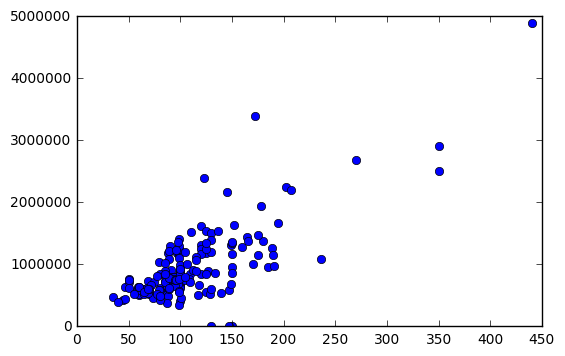

In [129]:
x_price = []
y_score = []
for zipcode in zip_code_agg_output:
    if zipcode in real_estate_agg:        
        x_price.append( np.median(zip_code_agg_output[zipcode])    )
        y_score.append( real_estate_agg[zipcode]  )
              
plt.plot(x_price, y_score, "o")
plt.show()

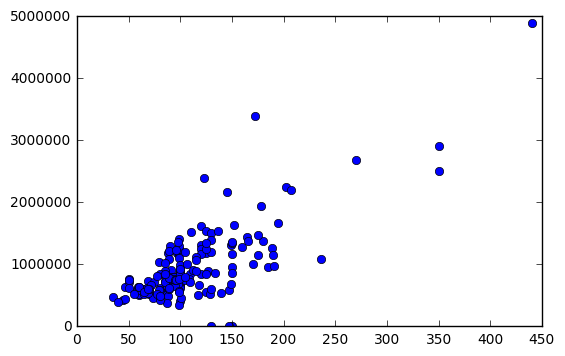

In [130]:
x_price = []
y_score = []
for zipcode in zip_code_agg_output:
    if zipcode in real_estate_agg:        
        x_price.append( np.median(zip_code_agg_output[zipcode])    )
        y_score.append( real_estate_agg[zipcode]  )
              
plt.plot(x_price, y_score, "o")
plt.show()

In [ ]:







#linmod = linear_model.LinearRegression()
#linmod.fit(np.array(x_price).reshape(1, -1), np.array(y_score).reshape(1, -1))
#linmod.coef_

In [8]:
real_estate['type'].unique()

array(['ZHVI', 'ZRI'], dtype=object)

In [25]:
zipcode_index = real_estate[real_estate['type'] == 'ZHVI'].loc[:,['zipcode','2017-06']]

In [10]:
zipcode_index['zipcode'] = np.array(map(str, zipcode_index['zipcode']))

In [44]:
zipcode_index['zipcode'] = zipcode_index['zipcode'].astype(str)

In [45]:
zipcode_index.head(n = 5)

,zipcode,2017-06
0,10025,1247000
1,60657,329100
2,60614,415500
3,79936,114700
4,60640,206700


In [46]:
len(zipcode_index)

13200

In [47]:
type(zipcode_index['zipcode'][0])


str

In [48]:
type(listings['zipcode'][0])

str

In [49]:
re_with_index = listings.merge(zipcode_index, on = 'zipcode', how = 'left')

In [50]:
re_with_index.iloc[1]

accommodates                                                2
amenities                                                  {}
availability_30                                            29
bathrooms                                                   1
bed_type                                             Real Bed
bedrooms                                                    1
beds                                                        1
cancellation_policy                                  flexible
city                                                 palmdale
has_availability                                          NaN
host_id                                              44800067
id                                                    8909380
instant_bookable                                            f
latitude                                              34.4854
longitude                                            -118.125
metropolitan                                               LA
name    

In [51]:
type(listings.iloc[1]['zipcode'])

str

In [54]:
type(re_with_index.iloc[1]['zipcode'])

str

In [ ]:
re_with_index.to_csv(sep = '\t')

In [17]:
zipcode_index.to_csv('/Users/chrisfan/Desktop/zipcode_index.csv', index=False)

In [55]:
re_with_index.to_csv('/Users/chrisfan/Desktop/listings_with_real_estate_index.csv')

In [35]:
len(re_with_index)

56417

In [20]:
len(listings)

56417

In [39]:
type(re_with_index['2017-06'][0])

numpy.float64

In [40]:
re_with_index['2017-06'].unique()

array([ nan])

In [56]:
re_with_index.groupby('2017-06').

,accommodates,amenities,availability_30,bathrooms,bed_type,bedrooms,beds,cancellation_policy,city,has_availability,...,review_scores_checkin,review_scores_cleanliness,review_scores_communication,review_scores_location,review_scores_rating,review_scores_value,room_type,state,weekly_price,zipcode
2017-06,,,,,,,,,,,,,,,,,,,,,
167100.0,1,1,1,1,1,1,1,1,1,0,...,0,0,0,0,0,0,1,1,0,1
205300.0,7,7,7,7,7,7,7,7,7,0,...,1,1,1,1,1,1,7,7,1,7
221800.0,10,10,10,10,10,10,10,10,10,0,...,5,5,5,5,5,5,10,10,1,10
238600.0,7,7,7,7,7,7,7,7,7,0,...,3,3,3,3,3,3,7,7,2,7
239300.0,16,16,16,16,16,16,16,16,16,0,...,12,12,12,12,12,12,16,16,3,16
269900.0,3,3,3,3,3,3,3,3,3,0,...,2,2,2,2,2,2,3,3,0,3
270200.0,3,3,3,3,3,3,3,3,3,0,...,2,2,2,2,2,2,3,3,0,3
282800.0,1,1,1,1,1,1,1,1,1,0,...,1,1,1,1,1,1,1,1,1,1
322300.0,14,14,14,14,14,14,14,14,14,0,...,9,9,9,9,9,9,14,14,4,14


In [68]:
venues['city'].unique()

array(['los angeles', 'oakland', 'san diego', 'san francisco',
       'santa cruz', 'seattle', 'portland'], dtype=object)

In [82]:
la_stores = venues[(venues['city'] == 'los angeles') & (venues.types.str.contains('store'))]

In [83]:
la_food = venues[(venues['city'] == 'los angeles') & (venues.types.str.contains('food'))]

In [84]:
la_transit = venues[(venues['city'] == 'los angeles') & (venues.types.str.contains('transit_station'))]

In [92]:
print(len(la_stores))
print(len(la_food))
print(len(la_transit))

27626
18108
14589


In [89]:
port_stores = venues[(venues['city'] == 'portland') & (venues.types.str.contains('store'))]
sc_stores = venues[(venues['city'] == 'santa cruz') & (venues.types.str.contains('store'))]
oak_stores = venues[(venues['city'] == 'oakland') & (venues.types.str.contains('store'))]
sd_stores = venues[(venues['city'] == 'san diego') & (venues.types.str.contains('store'))]
sf_stores = venues[(venues['city'] == 'san francisco') & (venues.types.str.contains('store'))]
sea_stores = venues[(venues['city'] == 'seattle') & (venues.types.str.contains('store'))]


In [90]:
port_food = venues[(venues['city'] == 'portland') & (venues.types.str.contains('food'))]
sc_food = venues[(venues['city'] == 'santa cruz') & (venues.types.str.contains('food'))]
oak_food = venues[(venues['city'] == 'oakland') & (venues.types.str.contains('food'))]
sd_food = venues[(venues['city'] == 'san diego') & (venues.types.str.contains('food'))]
sf_food = venues[(venues['city'] == 'san francisco') & (venues.types.str.contains('food'))]
sea_food = venues[(venues['city'] == 'seattle') & (venues.types.str.contains('food'))]

In [91]:
port_transit = venues[(venues['city'] == 'portland') & (venues.types.str.contains('transit_station'))]
sc_transit = venues[(venues['city'] == 'santa cruz') & (venues.types.str.contains('transit_station'))]
oak_transit = venues[(venues['city'] == 'oakland') & (venues.types.str.contains('transit_station'))]
sd_transit = venues[(venues['city'] == 'san diego') & (venues.types.str.contains('transit_station'))]
sf_transit = venues[(venues['city'] == 'san francisco') & (venues.types.str.contains('transit_station'))]
sea_transit = venues[(venues['city'] == 'seattle') & (venues.types.str.contains('transit_station'))]

In [139]:
print(len(sea_stores))
print(len(sea_food))
print(len(sea_transit))
print(sea_prices.median())

6410
3822
3085
100.0


In [140]:
print(len(oak_stores))
print(len(oak_food))
print(len(oak_transit))
print(oak_prices.median())

6375
3676
3679
95.0


In [141]:
print(len(port_stores))
print(len(port_food))
print(len(port_transit))
print(port_prices.median())

15341
7245
8406
90.0


In [142]:
print(len(sf_stores))
print(len(sf_food))
print(len(sf_transit))
print(sf_prices.median())

10761
6511
5025
160.0


In [143]:
print(len(sc_stores))
print(len(sc_food))
print(len(sc_transit))
print(sc_prices.median())

1484
635
430
150.0


In [144]:
print(len(sd_stores))
print(len(sd_food))
print(len(sd_transit))
print(sd_prices.median())

6862
3540
2473
135.0


In [102]:
city_stores = [len(sd_stores), len(oak_stores), len(port_stores), len(la_stores), len(sea_stores), len(sf_stores), len(sc_stores)]

In [103]:
city_food = [len(sd_food), len(oak_food), len(port_food), len(la_food), len(sea_food), len(sf_food), len(sc_food)]

In [104]:
city_transit = num_stores = [len(sd_transit), len(oak_transit), len(port_transit), len(la_transit), len(sea_transit), len(sf_transit), len(sc_transit)]

In [122]:
median_prices = []

sd_prices = listings[listings['city'] == 'san diego']['price'].str.replace('$', '').str.replace(',', '')
sd_prices = pd.to_numeric(sd_prices)

oak_prices = listings[listings['city'] == 'oakland']['price'].str.replace('$', '').str.replace(',', '')
oak_prices = pd.to_numeric(oak_prices)

sf_prices = listings[listings['city'] == 'san francisco']['price'].str.replace('$', '').str.replace(',', '')
sf_prices = pd.to_numeric(sf_prices)

sc_prices = listings[listings['city'] == 'santa cruz']['price'].str.replace('$', '').str.replace(',', '')
sc_prices = pd.to_numeric(sc_prices)

la_prices = listings[listings['city'] == 'los angeles']['price'].str.replace('$', '').str.replace(',', '')
la_prices = pd.to_numeric(la_prices)

sea_prices = listings[listings['city'] == 'seattle']['price'].str.replace('$', '').str.replace(',', '')
sea_prices = pd.to_numeric(sea_prices)

port_prices = listings[listings['city'] == 'portland']['price'].str.replace('$', '').str.replace(',', '')
port_prices = pd.to_numeric(port_prices)

median_prices.append(sd_prices.median())
median_prices.append(oak_prices.median())
median_prices.append(port_prices.median())
median_prices.append(la_prices.median())
median_prices.append(sea_prices.median())
median_prices.append(sf_prices.median())
median_prices.append(sc_prices.median())


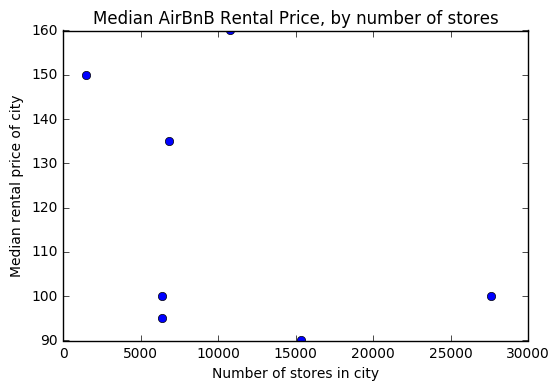

In [136]:
plt.plot(city_stores, median_prices, "o")
plt.title("Median AirBnB Rental Price, by number of stores")
plt.xlabel("Number of stores in city")
plt.ylabel("Median rental price of city")
plt.show()

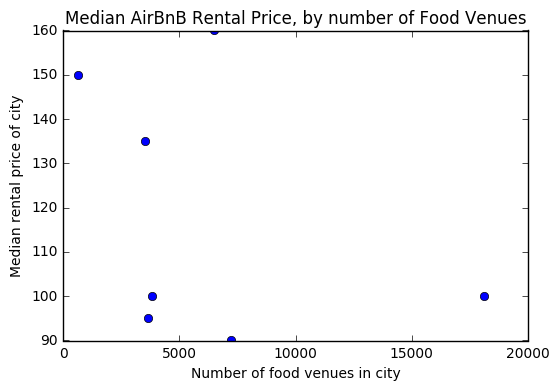

In [137]:
plt.plot(city_food, median_prices, "o")
plt.title("Median AirBnB Rental Price, by number of Food Venues")
plt.xlabel("Number of food venues in city")
plt.ylabel("Median rental price of city")
plt.show()

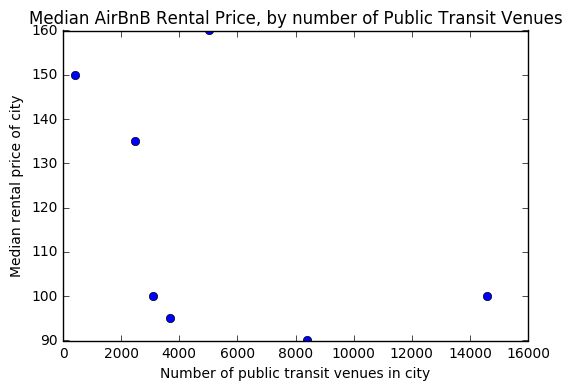

In [138]:
plt.plot(city_transit, median_prices, "o")
plt.title("Median AirBnB Rental Price, by number of Public Transit Venues")
plt.xlabel("Number of public transit venues in city")
plt.ylabel("Median rental price of city")
plt.show()

In [149]:
oak_transit_ratio = (float)(len(oak_transit)) / (len(venues[venues['city'] == 'oakland']))
print(oak_transit_ratio)

0.253811659193


In [150]:
port_transit_ratio = (float)(len(port_transit)) / (len(venues[venues['city'] == 'portland']))
print(port_transit_ratio)

0.285326363667


In [151]:
sc_transit_ratio = (float)(len(sc_transit)) / (len(venues[venues['city'] == 'santa cruz']))
print(sc_transit_ratio)

0.150297098916


In [152]:
sea_transit_ratio = (float)(len(sea_transit)) / (len(venues[venues['city'] == 'seattle']))
print(sea_transit_ratio)

0.212348568282


In [153]:
la_transit_ratio = (float)(len(la_transit)) / (len(venues[venues['city'] == 'los angeles']))
print(la_transit_ratio)

0.219409853817


In [154]:
sd_transit_ratio = (float)(len(sd_transit)) / (len(venues[venues['city'] == 'san diego']))
print(sd_transit_ratio)

0.174474389728


In [155]:
sf_transit_ratio = (float)(len(sf_transit)) / (len(venues[venues['city'] == 'san francisco']))
print(sf_transit_ratio)

0.209602068908


In [156]:
transit_ratios = []

transit_ratios.append(sd_transit_ratio)
transit_ratios.append(oak_transit_ratio)
transit_ratios.append(port_transit_ratio)
transit_ratios.append(la_transit_ratio)
transit_ratios.append(sea_transit_ratio)
transit_ratios.append(sf_transit_ratio)
transit_ratios.append(sc_transit_ratio)

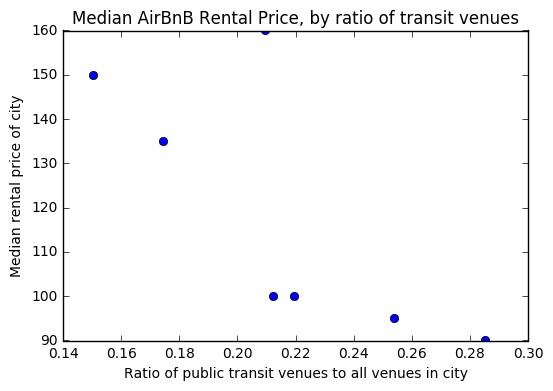

In [158]:
plt.plot(transit_ratios, median_prices, "o")
plt.title("Median AirBnB Rental Price, by ratio of transit venues")
plt.xlabel("Ratio of public transit venues to all venues in city")
plt.ylabel("Median rental price of city")
plt.show()

In [160]:
num_venues = []

num_venues.append(len(venues[venues['city'] == 'san diego']))
num_venues.append(len(venues[venues['city'] == 'oakland']))
num_venues.append(len(venues[venues['city'] == 'portland']))
num_venues.append(len(venues[venues['city'] == 'los angeles']))
num_venues.append(len(venues[venues['city'] == 'seattle']))
num_venues.append(len(venues[venues['city'] == 'san francisco']))
num_venues.append(len(venues[venues['city'] == 'santa cruz']))

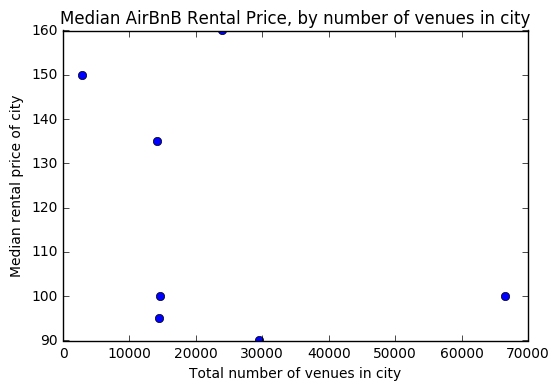

In [162]:
plt.plot(num_venues, median_prices, "o")
plt.title("Median AirBnB Rental Price, by number of venues in city")
plt.xlabel("Total number of venues in city")
plt.ylabel("Median rental price of city")
plt.show()